Predicting post-peak light-curve evolution using pre-peak data

In [8]:
import time 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LeakyReLU

sns.set_style('darkgrid')
df = pd.read_csv('lc_gp.csv', index_col='ztfname')

In [5]:
class PredictLC:
    def __init__(self, df):
        self.df = df
        self.predict_range = [0, 15]
        self.X = self.get_inputs()
        g_targets = df.columns[13+self.predict_range[0]:13+self.predict_range[1]]
        r_targets = df.columns[46:46+self.predict_range[1]]
        targets = np.append(g_targets.values, r_targets.values)
        self.models = dict(zip(targets, [None]*len(targets)))
        self.y_test_names = None
        
        self.model_pipeline()
        
    def get_inputs(self):
        data = self.df.drop(['t0g', 't0r', 'Av', 'z'], axis=1)
        gd = data.iloc[:, :13]
        rd = data.iloc[:, 33:46]
        dfx = pd.concat([gd, rd], axis=1)

        x_norm = dfx.values.flatten().min()
        x_mean = dfx.values.flatten().mean()
        return (dfx-x_mean)/(x_norm-x_mean)
    
    def generate_model(self, phase):
        tf.random.set_seed(42)
        y = self.df[phase]
        cond = (self.df.g0 < -18.5) & (self.df.g0 > -20)
        Xd, yd = self.X[cond], y[cond]
        X_, X_t, y_, y_t = train_test_split(Xd, yd, test_size=0.15, random_state=24)
        self.y_test_names = y_t.index.values
        X_train, X_test, y_train, y_test = X_.values, X_t.values, y_.values, y_t.values
        model = Sequential()
        l_r, b_1, b_2, eps, lrelu = (0.0009, 0.9, 0.999, 1e-8, 0.01)
        activation = LeakyReLU(lrelu)

        model.add(Dense(len(self.X.columns), activation=activation))
        model.add(Dense(48,activation=activation))
        model.add(Dropout(0.2))
        model.add(Dense(32,activation=activation))
        model.add(Dropout(0.1))
        model.add(Dense(16,activation=activation))
        model.add(Dense(1,activation='linear'))


        optimizer = Adam(
            learning_rate=l_r,
            beta_1=b_1,
            beta_2=b_2,
            epsilon=eps,
            amsgrad=False)

        model.compile(optimizer=optimizer,loss='mse')
        model.fit(x=X_train, y=y_train,
                   validation_data=(X_test, y_test),
                   batch_size=64,epochs=400, verbose=0)
        predictions = model.predict(X_test)
        print(f'Phase: {phase}, RMSE: {np.sqrt(np.mean((predictions-y_test)**2))}')
        
        errors = y_test - predictions.flatten()
        offset = stats.norm.fit(errors)[0]
        self.models[phase] = [model, offset]
        
    def model_pipeline(self):
        for phase in self.models.keys():
            self.generate_model(phase)
            
            
    def lc_pred(self, sn_name):
        if type(sn_name) == int:
            sn_name = self.y_test_names[sn_name]
        else:
            print('(!)Model trained on this LC(!)')
        early_lc = self.X.loc[sn_name]
        forcast = np.zeros(len(self.models))
        
        for i, key in enumerate(self.models.keys()):
            model, offset = self.models[key]
            forcast[i] = model.predict(np.expand_dims(early_lc, axis=0)) + offset
            
        lc = df.drop(['t0g', 't0r', 'Av', 'z'], axis=1).loc[sn_name]
        g_calli = lc.gm1 - forcast[0]
        r_calli = lc.r0 - forcast[self.predict_range[1]]
        g_pred = forcast[:self.predict_range[1]] + g_calli
        r_pred = forcast[self.predict_range[1]:] + r_calli
        
        fig, (ax1, ax2) = plt.subplots(figsize=(12, 12), nrows=2)
        x_lc = np.arange(-12, self.predict_range[1]+1)
        
        ax1.plot(x_lc, lc[:13+self.predict_range[1]], 'g.-', label='observed LC')
        ax2.plot(x_lc, lc[33:46+self.predict_range[1]], 'r.-', label='observed LC')
        ax1.plot(x_lc[:13], lc[:13], marker='s', linestyle='', color='g', 
                 markersize=7, label='training data')
        ax2.plot(x_lc[:13], lc[33:46], marker='s', linestyle='', color='r', 
                 markersize=7, label='training data')
        ax1.plot(x_lc[13:], g_pred, color='black', marker='o', linestyle='', 
                 label=f'predicted LC') # , shift: {g_calli:.2f}
        ax2.plot(x_lc[13:], r_pred, color='black', marker='o', linestyle='', 
                 label=f'predicted LC, shift: {r_calli:.2f}')
        ax1.invert_yaxis()
        ax2.invert_yaxis()
        ax1.legend()
        ax2.legend()
        return forcast

In [6]:
ann = PredictLC(df)

5/5 [==============================] - 0s 1ms/step
Phase: g1, RMSE: 0.44924807512785503
5/5 [==============================] - 0s 1ms/step
Phase: g2, RMSE: 0.45204844581422443
5/5 [==============================] - 0s 1ms/step
Phase: g3, RMSE: 0.45961141505236935
5/5 [==============================] - 0s 997us/step
Phase: g4, RMSE: 0.4783231079228088
5/5 [==============================] - 0s 1ms/step
Phase: g5, RMSE: 0.4745013497716525
5/5 [==============================] - 0s 998us/step
Phase: g6, RMSE: 0.48097382662678806
5/5 [==============================] - 0s 1ms/step
Phase: g7, RMSE: 0.5053398039845046
5/5 [==============================] - 0s 1ms/step
Phase: g8, RMSE: 0.5105722583432133
5/5 [==============================] - 0s 997us/step
Phase: g9, RMSE: 0.5250896047420087
5/5 [==============================] - 0s 922us/step
Phase: g10, RMSE: 0.537385614556026
5/5 [==============================] - 0s 997us/step
Phase: g11, RMSE: 0.5542885006545007
5/5 [=======================

1/1 [==============================] - 0s 14ms/step


array([-19.78181458, -19.75915718, -19.74463654, -19.70288658,
       -19.64203072, -19.61130714, -19.54431343, -19.46973801,
       -19.42062569, -19.35316277, -19.24221802, -19.16867447,
       -19.04143143, -18.97357368, -18.8810997 , -19.62524986,
       -19.6296711 , -19.60667992, -19.59493065, -19.55653191,
       -19.52951813, -19.48445511, -19.43422318, -19.37111855,
       -19.31340027, -19.24708366, -19.17492485, -19.1262722 ,
       -19.05734253, -19.00921631])

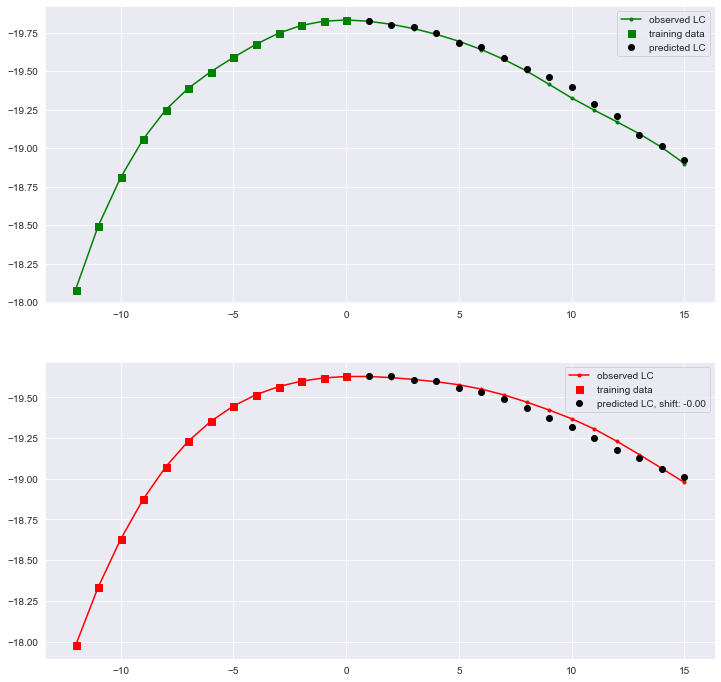

In [11]:
ann.lc_pred(15)